### Important

This notebook can be executed on a SageMaker Notebook instance within a `conda_pytorch_p36` env or within the appropriate Docker containers as mentioned in each relevant section. Some specific tests I performed required a combination of libraries which only an isolated container can provide.

## Intro

You can execute this section on a SageMaker Notebook instance within a `conda_pytorch_p36` env or within the `torch_trt` Docker container. It should work either way.

If you want to go with the Docker solution, run the following and attach a VSCode session to the running container.
```
> cd docker_torch_trt
> docker-compose build
> docker-compose -f docker-compose.yaml -f docker-compose.gpu.yaml run --rm -d torch_trt
```

In [1]:
import sagemaker
sagemaker.__version__

'2.117.0'

In [2]:
import torch
import torchvision.models as models
import tarfile
import json
import numpy as np
import time, os
print(f"CUDA is available: {torch.cuda.is_available()}")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available: True


In [2]:
resnet18 = models.resnet18(pretrained=True)
input_shape = [1, 3, 224, 224]
trace = torch.jit.trace(resnet18.float().eval(), torch.zeros(input_shape).float())
trace.save("model.pth")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available: True


/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import boto3

region = "eu-west-1"
os.environ["AWS_DEFAULT_REGION"] = region
role = "arn:aws:iam::257446244580:role/sagemaker-icevision"
sess = sagemaker.Session(boto_session=boto3.Session(region_name=region))
bucket = sess.default_bucket()
sm_runtime = boto3.Session().client("sagemaker-runtime", region_name=region)

## Deploy PyTorch model (TorchScript) to CPU and GPU instances

You can execute this section on a SageMaker Notebook instance within a `conda_pytorch_p36` env or within the `torch_trt` Docker container. It should work either way.

If you want to go with the Docker solution, run the following and attach a VSCode session to the running container.
```
> cd docker_torch_trt
> docker-compose build
> docker-compose -f docker-compose.yaml -f docker-compose.gpu.yaml run --rm -d torch_trt
```

In [4]:
with tarfile.open("model.tar.gz", "w:gz") as f:
    f.add("model.pth")
    f.add("serve_base.py")
    
model_uri = sess.upload_data(path="./model.tar.gz", key_prefix="neo_pytorch")
print(model_uri)

s3://sagemaker-eu-west-1-257446244580/neo_pytorch/model.tar.gz


We then create a PyTorchModel object, with default settings.

In [5]:
from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(
    model_data=model_uri,
    role=role,
    entry_point="serve_base.py",
    framework_version="1.5.0",
    py_version="py3",
)

# CHANGE `instance_type` TO `ml.g4dn.xlarge`/`ml.c5.xlarge` TO DEPLOY ON GPU/CPU
predictor = pytorch_model.deploy(instance_type="ml.g4dn.xlarge",
                                 endpoint_name="pytorch-endpoint",
                                 initial_instance_count=1)

-------!

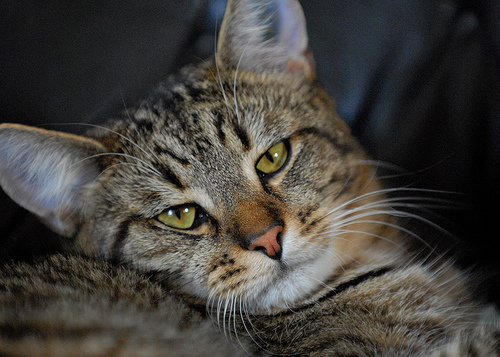

In [6]:
from PIL import Image
Image.open("cat.jpg")

In [7]:
with open("cat.jpg", "rb") as f:
    payload = f.read()

response = sm_runtime.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="application/x-image", Body=payload
)
result = json.loads(response["Body"].read().decode())
print("Most likely class: {}".format(np.argmax(result)))

Most likely class: 282


In [8]:
object_categories = {}
with open("imagenet_labels.txt", "r") as f:
    for line in f:
        key, val = line.strip().split(":")
        object_categories[key] = val
print(
    "Result: label - "
    + object_categories[str(np.argmax(result))]
    + " probability - "
    + str(np.amax(result))
)

Result: label -  'tiger cat', probability - 15.121315002441406


In [18]:
%%timeit
_ = sm_runtime.invoke_endpoint(EndpointName=predictor.endpoint_name, ContentType="application/x-image", Body=payload)

30.6 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
predictor.delete_model()
predictor.delete_endpoint()

## Compile PyTorch model to Neo and deploy to Inferentia (or any other hardware)

You can execute this section on a SageMaker Notebook instance within a `conda_pytorch_p36` env or within the `torch_trt` Docker container. It should work either way.

If you want to go with the Docker solution, run the following and attach a VSCode session to the running container.
```
> cd docker_torch_trt
> docker-compose build
> docker-compose -f docker-compose.yaml -f docker-compose.gpu.yaml run --rm -d torch_trt
```

In [4]:
with tarfile.open("model.tar.gz", "w:gz") as f:
    f.add("model.pth")
    f.add("serve_neo.py")
    
model_uri = sess.upload_data(path="./model.tar.gz", key_prefix="neo_pytorch")
print(model_uri)

s3://sagemaker-eu-west-1-257446244580/neo_pytorch/model.tar.gz


In [5]:
from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(
    model_data=model_uri,
    role=role,
    entry_point="serve_neo.py",
    framework_version="1.5.0",
    py_version="py3",
)

# CHANGE `target_instance_family` TO `ml_c5`/`ml_inf1` TO COMPILE FOR c5/Inferentia HARDWARE
pytorch_model = pytorch_model.compile(
    target_instance_family="ml_c5",
    input_shape={"input0": [1, 3, 224, 224]},
    output_path=model_uri,
    framework="pytorch",
    framework_version="1.5.1",
    role=role,
    job_name=f"neo-pytorch-{int(time.time())}",
)

# CHANGE `instance_type` TO `ml.c5.xlarge`/`ml.inf1.xlarge` TO DEPLOY ON CPU/Inferentia
predictor = pytorch_model.deploy(instance_type="ml.c5.xlarge",
                                 endpoint_name="pytorch-endpoint",
                                 initial_instance_count=1)

???????????????????????????.................................!----!

In [6]:
with open("cat.jpg", "rb") as f:
    payload = f.read()

response = sm_runtime.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="application/x-image", Body=payload
)
result = json.loads(response["Body"].read().decode())
print("Most likely class: {}".format(np.argmax(result)))

Most likely class: 282


In [14]:
%%timeit
_ = sm_runtime.invoke_endpoint(EndpointName=predictor.endpoint_name, ContentType="application/x-image", Body=payload)

64.6 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
predictor.delete_model()
predictor.delete_endpoint()

## Torchvision to NVIDIA TensorRT: deploy to SageMaker with custom Docker container + local benchmark

You can execute this section ONLY within the `torch_trt` Docker container. 
Run the following and attach a VSCode session to the running container.
```
> cd docker_torch_trt
> docker-compose build
> docker-compose -f docker-compose.yaml -f docker-compose.gpu.yaml run --rm -d torch_trt
```

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch_tensorrt
import numpy as np
torch.cuda.is_available()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
def input_fn(path, dtype="fp32"):
    input_image = Image.open(path).convert("RGB")
    preprocess = transforms.Compose(
        [
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    input_tensor = preprocess(input_image).unsqueeze(0)
    if dtype == "fp16":
        return input_tensor.half().cuda()
    else:
        return input_tensor.cuda()
    

def predict_fn(m, x):
    with torch.inference_mode():
        prediction = m(x)
    return np.argmax(prediction.cpu())

In [7]:
resnet18 = models.resnet18(pretrained=True).eval().to("cuda")

trt_model = torch_tensorrt.compile(resnet18, 
    inputs = [torch_tensorrt.Input((1, 3, 224, 224), dtype=torch.half)],
    enabled_precisions = {torch.half}, # Run with FP16
)

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True


In [14]:
input_batch = input_fn("cat.jpg", dtype="fp16")

print(f"Most likely class: {predict_fn(trt_model, input_batch)}")

Most likely class: 282


In [9]:
trt_model.save("trt_model.pth")

In [11]:
model_reloaded = torch.jit.load("trt_model.pth").eval().to("cuda")
input_batch = input_fn("cat.jpg", dtype="fp16")
print(f"Most likely class: {predict_fn(model_reloaded, input_batch)}")

Most likely class: 282


In [12]:
%%timeit -r 10
with torch.inference_mode():
    _ = model_reloaded(input_batch)

1.06 ms ± 3.99 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


### Deploy TensorRT model to SageMaker with custom Docker container

In [1]:
!tar -cvpzf model.tar.gz trt_model.pth
!mv model.tar.gz tensorrt_sagemaker_deploy/opt/ml/model/

trt_model.pth


```
> cd tensorrt_sagemaker_deploy
> ./build_and_push_to_ecr.sh
```

In [1]:
import boto3, sagemaker, base64, json
import numpy as np

region = "eu-west-1"
role = "arn:aws:iam::257446244580:role/sagemaker-icevision"
sess = sagemaker.Session(boto_session=boto3.Session(region_name=region))
bucket = sess.default_bucket()
sm_runtime = boto3.Session().client("sagemaker-runtime", region_name=region)

In [2]:
model_uri = sess.upload_data(path="./tensorrt_sagemaker_deploy/opt/ml/model/model.tar.gz", key_prefix="trt_pytorch")
print(model_uri)

s3://sagemaker-eu-west-1-257446244580/trt_pytorch/model.tar.gz


In [2]:
model = sagemaker.model.Model(image_uri="257446244580.dkr.ecr.eu-west-1.amazonaws.com/custom-images:trt_pytorch",
                              name="trt-pytorch",
                              model_data="s3://sagemaker-eu-west-1-257446244580/trt_pytorch/model.tar.gz",
                              role=role,
                              sagemaker_session=sess,
                              predictor_cls=sagemaker.Predictor
                             )

predictor = model.deploy(initial_instance_count=1, 
                         instance_type='ml.g4dn.xlarge', 
                         endpoint_name="trt-pytorch",)

-----------!

In [6]:
with open("cat.jpg", "rb") as img_file:
    b64_string = base64.b64encode(img_file.read())

response = predictor.predict('{"image": "'+b64_string.decode('utf-8')+'"}')
result = json.loads(response.decode())
print("Most likely class: {}".format(np.argmax(result)))

Most likely class: 282


In [5]:
predictor = sagemaker.Predictor(endpoint_name='trt-pytorch', sagemaker_session=sess)

In [12]:
%%timeit
_ = predictor.predict('{"image": "'+b64_string.decode('utf-8')+'"}')

14.6 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
predictor.delete_model()
predictor.delete_endpoint()

## Compile ResNet18 with SageMaker Neo and run locally on GPU with the `neo-ai-dlr` library

You can execute this section ONLY within the `neo_dlr` Docker container. 
Run the following and attach a VSCode session to the running container.
```
> cd docker_neo_dlr
> docker-compose build
> docker-compose -f docker-compose.yaml -f docker-compose.gpu.yaml run --rm -d neo_dlr
```

Compile the ResNet18 model with Amazon SageMaker Neo 

In [4]:
import torch
import torchvision.models as models
import tarfile
import json
import numpy as np
import time
import sagemaker, boto3, os

resnet18 = models.resnet18(pretrained=True)
input_shape = [1, 3, 224, 224]
trace = torch.jit.trace(resnet18.float().eval(), torch.zeros(input_shape).float())
trace.save("model.pth")

region = "eu-west-1"
os.environ["AWS_DEFAULT_REGION"] = region
role = "arn:aws:iam::257446244580:role/sagemaker-icevision"
sess = sagemaker.Session(boto_session=boto3.Session(region_name=region))
sm_runtime = boto3.Session().client("sagemaker-runtime", region_name=region)

with tarfile.open("model.tar.gz", "w:gz") as f:
    f.add("model.pth")
    f.add("serve_neo.py")
    
model_uri = sess.upload_data(path="./model.tar.gz", key_prefix="neo_pytorch")
print(model_uri)

from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(
    model_data=model_uri,
    role=role,
    entry_point="serve_neo.py",
    framework_version="1.12",
    py_version="py3",
)

pytorch_model = pytorch_model.compile(
    target_instance_family="ml_g4dn",
    input_shape={"input0": [1, 3, 224, 224]},
    output_path=model_uri,
    framework="pytorch",
    framework_version="1.12",
    role=role,
    job_name=f"neo-pytorch-{int(time.time())}",
)

Download compiled model from S3 to local

In [6]:
s3_client = boto3.client('s3')
s3_client.download_file('sagemaker-eu-west-1-257446244580', 'neo_pytorch/model.tar.gz/model-ml_g4dn.tar.gz', 'model-ml_g4dn.tar.gz')

Untar model and save to dedicated local directory

In [8]:
!mkdir ./dlr_model # make a directory to store your model (optional)
!tar -xzvf ./model-ml_g4dn.tar.gz --directory ./dlr_model

IOC-INF/
IOC-INF/metadata.json
1435857361_0_Neo.so
1435857361_0_Neo.meta
sample_input.pkl
model.pt
1435857361_0_Neo.json
1435857361_0_Neo.params
manifest


In [12]:
# https://neo-ai-dlr.readthedocs.io/en/latest/install.html#building-for-nvidia-gpu-cloud-or-desktop
import dlr

In [2]:
device = 'gpu'
neo_model = dlr.DLRModel('./dlr_model', device)

2022-11-27 22:24:13,075 INFO Could not find libdlr.so in model artifact. Using dlr from /root/.local/lib/python3.6/site-packages/dlr-1.10.0-py3.6.egg/dlr/libdlr.so


In [5]:
from PIL import Image
import numpy as np

def input_fn_neo(path):
    image = Image.open(path).convert("RGB")
    image = image.resize((224, 224))
    x = np.array(image).astype('float32') / 255.
    
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    x = (x - mean) / std
    
    return np.swapaxes(x, 0, -1)[None] # shape = (1, 3, 224, 224)

input_batch = input_fn_neo("cat.jpg")
input_batch.shape


(1, 3, 224, 224)

In [6]:
out = neo_model.run(input_batch)
print(f"Most likely class: {np.argmax(out[0])}")

Most likely class: 282


In [10]:
%%timeit -r 10
_ = neo_model.run(input_batch)

1.82 ms ± 58.9 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


## Local GPU benchmarks: TensorRT vs Neo vs No optimization

*Note*: Executing inside the `torch_trt` Docker container. 
* CUDA version (inside container): `11.6`
* CUDA driver (outside the container, on the host machine): `510.39.01`

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def input_fn(path, dtype="fp32"):
    input_image = Image.open(path).convert("RGB")
    preprocess = transforms.Compose(
        [
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    input_tensor = preprocess(input_image).unsqueeze(0)
    if dtype == "fp16":
        return input_tensor.half().cuda()
    else:
        return input_tensor.cuda()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1️⃣ Model with no optimization on GPU
Model saved in the `Intro` section

In [2]:
no_optim_model = torch.jit.load("model.pth").eval().to("cuda")
input_batch = input_fn("cat.jpg", dtype="fp32")

In [4]:
%%timeit -r 10
with torch.inference_mode():
    _ = no_optim_model(input_batch)

1.85 ms ± 18.6 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


#### 2️⃣ FP16 TensorRT on GPU

In [6]:
import torch_tensorrt
trt_model = torch.jit.load("trt_model.pth").eval().to("cuda")
input_batch = input_fn("cat.jpg", dtype="fp16")

In [8]:
%%timeit -r 10
with torch.inference_mode():
    _ = trt_model(input_batch)

1.06 ms ± 9.85 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


#### 3️⃣ Neo compiled model on GPU

*Note*: Executing inside the `neo_dlr` Docker container. 
* CUDA version (inside container): `10.2`
* CUDA driver (outside the container, on the host machine): `440.33.01`

In [ ]:
import dlr

device = 'gpu'
neo_model = dlr.DLRModel('./dlr_model', device)

input_batch = input_fn_neo("cat.jpg")

In [11]:
%%timeit -r 10
_ = neo_model.run(input_batch)

1.8 ms ± 55.7 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
